# Data Cleaning and EDA
## 1. Data Preprocessing & Initial Exploration
**Technical Overview:** The initial dataset consists of 541,909 records and 8 features. Initial inspection reveals a significant number of missing values in the CustomerID column (~25%), which is critical for individual-level analysis. Data types require adjustment, specifically converting InvoiceDate to a datetime object and standardizing ID fields.

**Data Cleaning Strategy:**
- Handling Nulls: Removal of records without a CustomerID to ensure individual tracking.
- Outlier Removal: Filtering extreme Quantity values and non-revenue transaction types (e.g., Bank Charges, Postage).
- Feature Engineering: Creation of a TotalPrice column representing the gross revenue per line item.
- Segmentation of Dataframes: Separation of sales and returns to analyze net customer behavior.

In [ ]:
import pandas as pd

# load dataset with specific encoding for special characters
data = pd.read_csv('../data/raw_data.csv', encoding='ISO-8859-1')

# basic data exploration
print("Data info:\n")
data.info()

print("\nInitial data shape: ", data.shape)

print("\nData desciption:")
display(data.describe())

print("\nFirst 5 rows:")
display(data.head())

Data info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB

Initial data shape:  (541909, 8)

Data desciption:


,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000



First 5 rows:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
data = data.drop_duplicates()

# standardize data types
data['InvoiceNo'] = data['InvoiceNo'].astype(str)
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# handle missing values for customer identification
data = data.dropna(subset='CustomerID')
data['CustomerID'] = data['CustomerID'].astype(str)

# filter outliers and invalid transactions
data = data[(data['Quantity']>-10000) & (data['Quantity']<10000)]
data = data[data['UnitPrice']>0]

# remove non-product codes (adjusting for retail-specific tags)
data = data[~data['StockCode'].isin(['D', 'DOT', 'POST', 'M', 'BANK CHARGES'])]

# create a new colum after cleaning
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']

# split data into sales and returns for focused analysis
returns = data[(data['Quantity'] < 0)]
sales = data[(data['Quantity'] > 0)]

data.to_csv('../data/cleaned_data.csv')

## 2. RFM Segmentation Model

**Objective:** Implementing an RFM (Recency, Frequency, Monetary) model to quantify customer value. Customers are ranked on a scale of 1-5 across three dimensions, resulting in 125 possible combinations mapped into distinct strategic segments.

**Segmentation logic:**
- Recency (R): Days since last purchase (Inverted scale: 5 is most recent).
- Frequency (F): Number of unique transactions.
- Monetary (M): Total lifetime spend.

**Segment Distribution Analysis:** The bar chart reveals that 'Champions' and 'Hibernating / Lost' are the two largest groups. This polarization suggests a business with a strong core of loyalists but also a significant portion of inactive users who require immediate re-engagement or churn analysis.

In [ ]:
snapshot_date = sales['InvoiceDate'].max() + pd.Timedelta(days=1)

# aggregate customer behavior metrics
rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})

# assign RFM scores using quintiles
r_labels = range(5, 0, -1)
f_labels = range(1, 6)
m_labels = range(1, 6)

rfm.columns = ['Recency', 'Frequency', 'Monetary']

rfm['R'] = pd.qcut(rfm['Recency'], q=5, labels=r_labels)
rfm['F'] = pd.qcut(rfm['Frequency'].rank(method='first'), q=5, labels=f_labels)
rfm['M'] = pd.qcut(rfm['Monetary'], q=5, labels=m_labels)

# concatenate R and F scores for segmentation
rfm['RF_Group'] = rfm['R'].astype(str) + rfm['F'].astype(str)

# define customer segments based on RFM scores
segment_map = {
    r'[4-5][4-5]': 'Champions',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'3[4-5]': 'At Risk - Loyal',
    r'[2-3][2-3]': 'Customers Needing Attention',
    r'1[4-5]': 'Cant Lose Them',
    r'[1-2][1-2]': 'Hibernating / Lost',
    r'[4-5]1': 'New Customers',
    r'31': 'About To Sleep',
    r'13': 'At Risk',
    r'[2-3]4': 'Loyal Customers',
    r'25': 'Loyal Customers'
}

rfm['Segment'] = rfm['RF_Group'].replace(segment_map, regex=True)

print(rfm[['R', 'F', 'M', 'Segment']].head())

            R  F  M             Segment
CustomerID                             
12347.0     5  4  5           Champions
12348.0     2  4  4     Loyal Customers
12349.0     4  1  4       New Customers
12350.0     1  1  2  Hibernating / Lost
12352.0     3  5  4     At Risk - Loyal


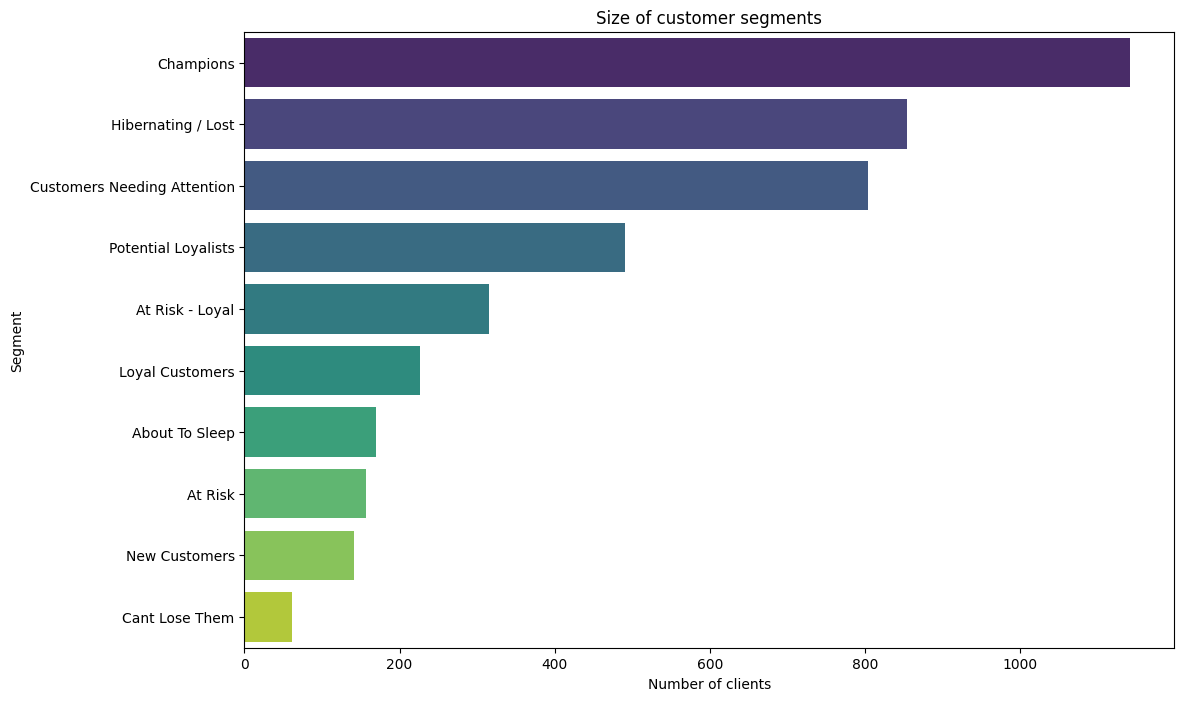

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# visualize customer segment distribution
plt.figure(figsize=(12, 8))
segment_counts = rfm['Segment'].value_counts()

sns.barplot(x=segment_counts.values, y=segment_counts.index, palette='viridis', hue=segment_counts.index, legend=False)
plt.title('Size of customer segments')
plt.xlabel('Number of clients')
plt.show()

## 3. Strategic Segment Profiling

### Key Business Insights:

**The Pareto Effect:** The 'Champions' segment significantly outspends all other groups, with an average monetary value of ~4.990, which is more than double the next highest segment ('At Risk - Loyal' at ~2.292).

**At Risk - Loyal:** This group is high-value but hasn't purchased in ~49 days on average. They represent the highest priority for retention marketing.

**New Customers:** While currently having the lowest monetary value (approximately 316.8), their low recency (~18 days) makes them prime candidates for onboarding sequences to move them toward 'Potential Loyalists'.

                                Recency  Frequency     Monetary
Segment                                                        
Champions                     12.315236  11.896673  4990.352636
At Risk - Loyal               49.180952   6.819048  2292.440670
Cant Lose Them               236.081967   6.049180  2208.255574
Loyal Customers              107.862832   5.818584  1673.773938
Potential Loyalists           16.319756   2.207739   679.998554
Customers Needing Attention   87.099502   2.055970   628.450833
At Risk                      246.203822   2.426752   512.810006
About To Sleep                52.658824   1.000000   378.160706
Hibernating / Lost           240.558548   1.115925   353.020622
New Customers                 17.858156   1.000000   316.805816 



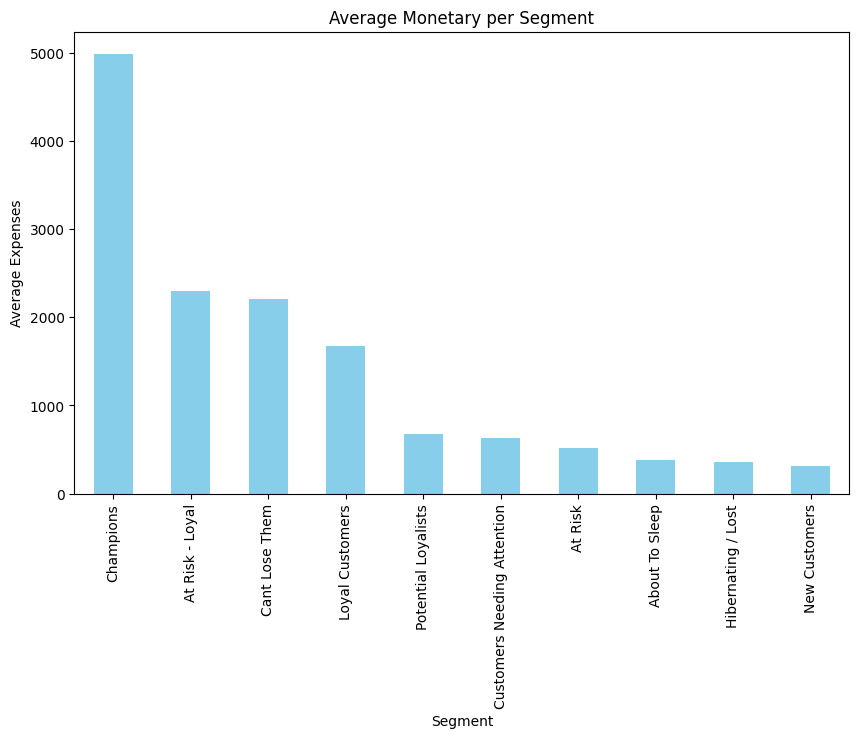

In [13]:
# deep dive into segment behavior
segment_profile = rfm.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
}).sort_values('Monetary', ascending=False)

print(segment_profile, "\n")

# compare average spending across segments
plt.figure(figsize=(10, 6))
segment_profile['Monetary'].plot(kind='bar', color='skyblue')
plt.title('Average Monetary per Segment')
plt.ylabel('Average Expenses')
plt.show()

## 4. Market Basket Analysis (Association Rules)

**Technical Methodology:** Using the Apriori Algorithm, we analyzed transaction patterns to identify product affinities. We focused on rules with a Lift > 1, indicating a relationship stronger than random chance.

**Top Findings (Teacup Regency Collection):** The analysis reveals extremely strong associations within the "Regency Teacup" product line:
- **Rule 1:** {Green Regency, Roses Regency} -> {Pink Regency} shows a Lift of 22.35.
- **Confidence Level:** The 89.4% confidence in the {Pink & Roses} -> {Green} rule suggests that customers almost always complete the set when buying two colors.
- **Actionable Insight:** These items should be bundled together in "Complete Your Set" promotions or placed adjacently in the webstore to maximize Cross-Selling.

In [ ]:
from mlxtend.frequent_patterns import apriori, association_rules
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Market Basket Analysis (MBA) using Apriori algorithm
basket = (sales.groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))

# transform quantities into binary indicators
def encode_units(x):
    if x <= 0: return 0
    if x >= 1: return 1

basket_sets = basket.map(encode_units)
basket_sets = basket_sets[(basket_sets.sum(axis=1) > 1)]

# generate association rules
frequent_itemsets = apriori(basket_sets, min_support=0.02, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules = rules.sort_values('lift', ascending=False)

print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())

                                          antecedents  \
91  (GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...   
94                   (PINK REGENCY TEACUP AND SAUCER)   
92  (PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...   
93                  (GREEN REGENCY TEACUP AND SAUCER)   
10                  (GREEN REGENCY TEACUP AND SAUCER)   

                                          consequents   support  confidence  \
91                   (PINK REGENCY TEACUP AND SAUCER)  0.022822    0.720887   
94  (GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...  0.022822    0.707804   
92                  (GREEN REGENCY TEACUP AND SAUCER)  0.022822    0.894495   
93  (PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...  0.022822    0.564399   
10                   (PINK REGENCY TEACUP AND SAUCER)  0.026918    0.665702   

         lift  
91  22.357971  
94  22.357971  
92  22.121609  
93  22.121609  
10  20.646424  


In [ ]:
# filter for strong product associations
top_rules = rules[(rules['lift'] > 3) & (rules['confidence'] > 0.5)]
print(top_rules[['antecedents', 'consequents', 'lift', 'confidence']].head(10))

                                          antecedents  \
91  (GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...   
94                   (PINK REGENCY TEACUP AND SAUCER)   
92  (PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...   
93                  (GREEN REGENCY TEACUP AND SAUCER)   
10                  (GREEN REGENCY TEACUP AND SAUCER)   
11                   (PINK REGENCY TEACUP AND SAUCER)   
90  (GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...   
82                   (PINK REGENCY TEACUP AND SAUCER)   
83                 (ROSES REGENCY TEACUP AND SAUCER )   
15                 (ROSES REGENCY TEACUP AND SAUCER )   

                                          consequents       lift  confidence  
91                   (PINK REGENCY TEACUP AND SAUCER)  22.357971    0.720887  
94  (GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...  22.357971    0.707804  
92                  (GREEN REGENCY TEACUP AND SAUCER)  22.121609    0.894495  
93  (PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...  2

## 5. Customer Retention & Cohort Analysis

### Cohort Insights:

**Initial Loyalty (2010-12):** The first cohort shows exceptional health, with a 50% retention rate even after 11 months. This suggests that early adopters are the most stable revenue source.

**The "Spring Dip":** Cohorts acquired between March and May 2011 show lower month-1 retention (~19-22%) compared to the yearly average. This may indicate seasonal churn or less effective acquisition campaigns during that period.

**Immediate Churn:** The November 2011 cohort shows a sharp drop to 13% in month 1. This requires further investigation—potentially due to one-time holiday shoppers who did not find a reason to return.

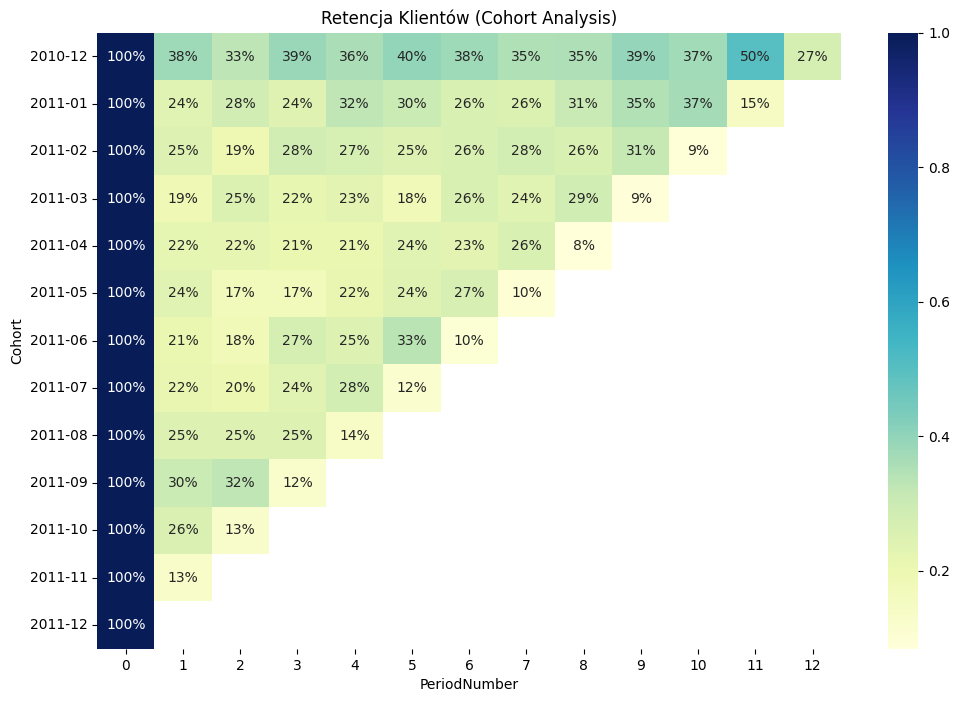

In [11]:
data['OrderMonth'] = data['InvoiceDate'].dt.to_period('M')
data['Cohort'] = data.groupby('CustomerID')['OrderMonth'].transform('min')

# calculate monthly customer retention rates
cohort_data = data.groupby(['Cohort', 'OrderMonth']).agg(n_customers=('CustomerID', 'nunique')).reset_index()
cohort_data['PeriodNumber'] = (cohort_data.OrderMonth - cohort_data.Cohort).apply(lambda x: x.n)

# pivot and visualize retention heatmap
cohort_pivot = cohort_data.pivot_table(index='Cohort', columns='PeriodNumber', values='n_customers')
retention_matrix = cohort_pivot.divide(cohort_pivot.iloc[:,0], axis=0)

plt.figure(figsize=(12, 8))
sns.heatmap(retention_matrix, annot=True, fmt='.0%', cmap='YlGnBu')
plt.title('Customer Retention (Cohort Analysis)')
plt.show()

Based on these insights, the project will move toward a Churn Prediction Model, utilizing the engineered RFM features and Return Rates to identify at-risk customers before they enter the 'Lost' segment.